 # [Lecture 18 - Missing Data](https://www.youtube.com/watch?v=Oeq6GChHOzc)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2023-09-14T22:59:26.402463-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

scipy      : 1.11.2
numpy      : 1.24.4
pymc       : 5.8.0
statsmodels: 0.14.0
pandas     : 2.1.0
matplotlib : 3.7.2
arviz      : 0.16.1
xarray     : 2023.8.0



# Missing Data, Found
- Observed data is a special case
  - we trick ourselves into believing there is no error
  - no/little error is rare

Most data are missing
  - but there's still information about the missing data. no data is fully missing with a generative model
  1. constraints - e.g. heights are never negative, and bounded
  2. relationships to other variables - e.g. weather affects our behavior, our behavior does not affect the weather


## Dealing with missing data is a workflow

#### What to do with missing data?

- **Complete case analysis**: drop cases missing values
  - sometimes the right thing to do
  - depends on the context and causal assumptions
- **Imputation**: fill the missing values with reasonable values that are based on the present values
  - often necessary and benefitial for accurate estimation
 
## Dog ate my homework: looking a different missing data scenarios

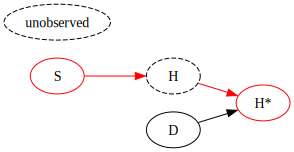

In [61]:
utils.draw_causal_graph(
    edge_list=[
        ("S", "H"),
        ("H", "H*"),
        ("D", "H*")
    ],
    node_props={
        "S": {"color": "red"},
        "H*": {"color": "red"},
        "H": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "H*"): {"color": "red"},
    },
    graph_direction="LR"
)

- Student ability/knowledge state $S$
- Students would receive score on homework $H$
- We only get to observe the homework the teacher sees $H^*$
  - we don't get to observe the real score, because homework may not make it to teacher
  - e.g. the family dog $D$ randomly eats homework (missingness mechanism)

### Dog usually benign

In [3]:
# Helper functions
def plot_regression_line(x, y, color, label, **plot_kwargs):
    valid_idx = ~np.isnan(y)
    
    X = np.vstack((np.ones_like(x[valid_idx]), x[valid_idx])).T
    intercept, slope = np.linalg.lstsq(X, y[valid_idx])[0]
    
    xs = np.linspace(x.min(), x.max(), 10)
    ys = xs * slope + intercept
    utils.plot_line(xs, ys, color=color, label=label, **plot_kwargs)

def plot_dog_homework(S, H, Hstar, title=None):
    
    utils.plot_scatter(
        S, H, color='k', alpha=1, label='total', s=10
    )
    plot_regression_line(S, H, label='total trend', color='k', alpha=.5)
    
    utils.plot_scatter(
        S, Hstar, color='C0', alpha=.8, label='incomplete'
    )
    plot_regression_line(S, Hstar, label='incomplete trend', color='C0', alpha=.5)
    
    plt.xlabel("S")
    plt.ylabel("H")
    plt.title(title)
    plt.legend();


#### Simulate random homework eating

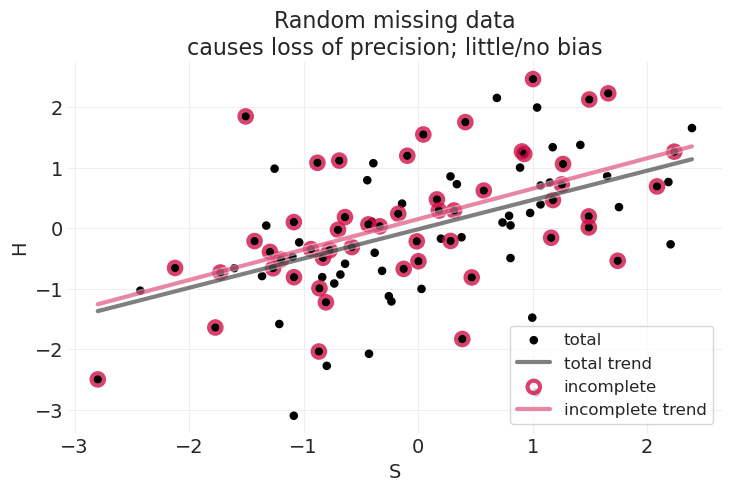

In [4]:
np.random.seed(123)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 50% of of homework _at random_
D = stats.bernoulli(0.5).rvs(size=n_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Random missing data\ncauses loss of precision; little/no bias")

- When losing outcomes randomly, we obtain a similar linear fit with the similar slope, and no little/no bias.
- Thus dropping complete cases ok, but lose efficiency

### Dog eats homework based on cause of homework (student ability)

Now the student's ability effects the dog's behavior (e.g. the student studies too much and doesn't feed the dog, and the dog is hungry)


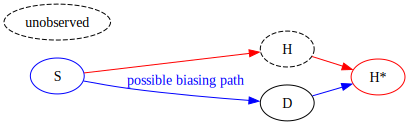

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("S", "H"),
        ("H", "H*"),
        ("D", "H*"),
        ("S", "D")
    ],
    node_props={
        "S": {"color": "blue"},
        "H*": {"color": "red"},
        "H": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "H*"): {"color": "red"},
        ("S", "D"): {"color": "blue", "label": "possible biasing path", "fontcolor": "blue"},
        ("D", "H*"): {"color": "blue"},
    },
    graph_direction="LR"
)

#### Simulate data where treatment effects oucome linearly

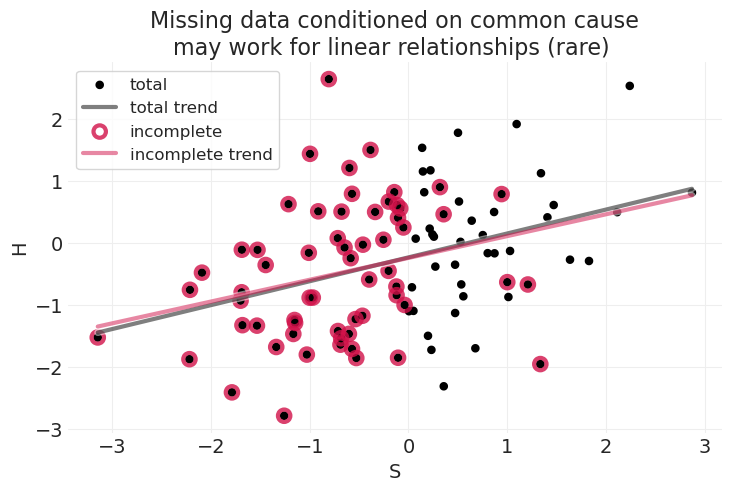

In [6]:
np.random.seed(12)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between student ability and homework score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats based on the student's ability
p_dog_eats_homework = np.where(S > 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on common cause\nmay work for linear relationships (rare) ")

When the association between student ability $S$ and homework sckor $H$ is linear, we can still get fairly similar linear fits from the total and incomplete sample, you just lose precision on one the upper end of the $S$ dimenions in this simulation

#### Simulate data where treatment effects oucome nonlinearly

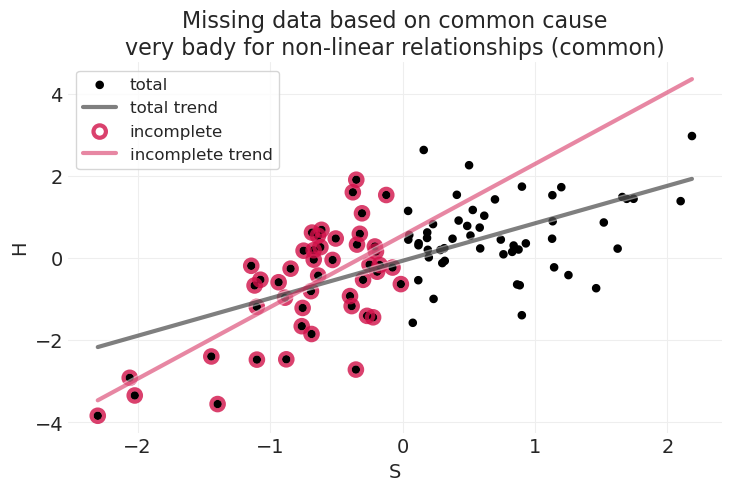

In [7]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Nonlinear association between student ability and homework score
mu_score = 1 - np.exp(-0.7 * S)
H = stats.norm.rvs(mu_score)

# Dog eats all the homework of above-average students
p_dog_eats_homework = np.where(S > 0, 1, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data based on common cause\nvery bady for non-linear relationships (common)")

- When the association between student ability $S$ and homework sckor $H$ is nonlinear, we now get very different linear fits from the total and incomplete sample
  - on nonlinearity: this is why we use generative models with scientifically-motivated functions: **functions matter**
- Therefore need to correctly condition on the cause

### Dog eats homework conditioned on the _state_ of homework itself

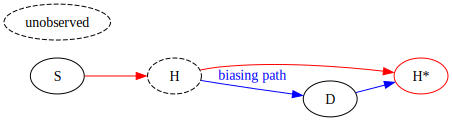

In [8]:
utils.draw_causal_graph(
    edge_list=[
        ("S", "H"),
        ("H", "H*"),
        ("D", "H*"),
        ("H", "D")
    ],
    node_props={
        "H*": {"color": "red"},
        "H": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    
    },
    edge_props={
        ("S", "H"): {"color": "red"},
        ("H", "H*"): {"color": "red"},
        ("H", "D"): {"color": "blue", "label": "biasing path", "fontcolor": "blue"},
        ("D", "H*"): {"color": "blue"},
    },
    graph_direction="LR"
)

#### Simulate some linear data

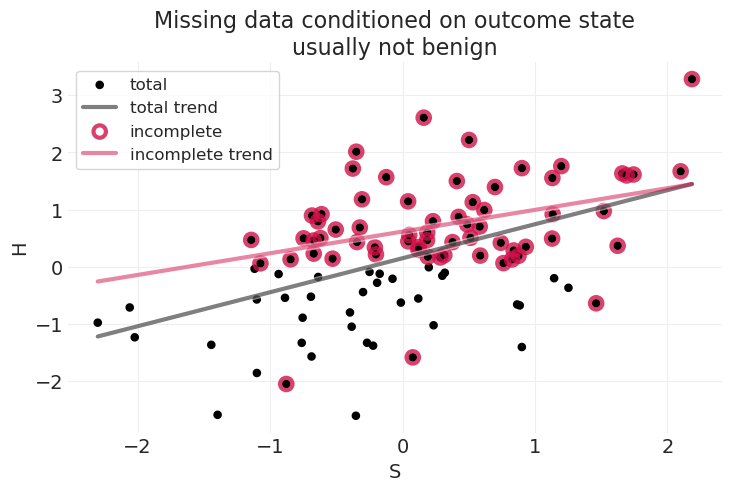

In [9]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Linear association between ability and score
mu_score = S * 0.5
H = stats.norm.rvs(mu_score)

# Dog eats 90% of homework that is below average
p_dog_eats_homework = np.where(H < 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on outcome state\nusually not benign")

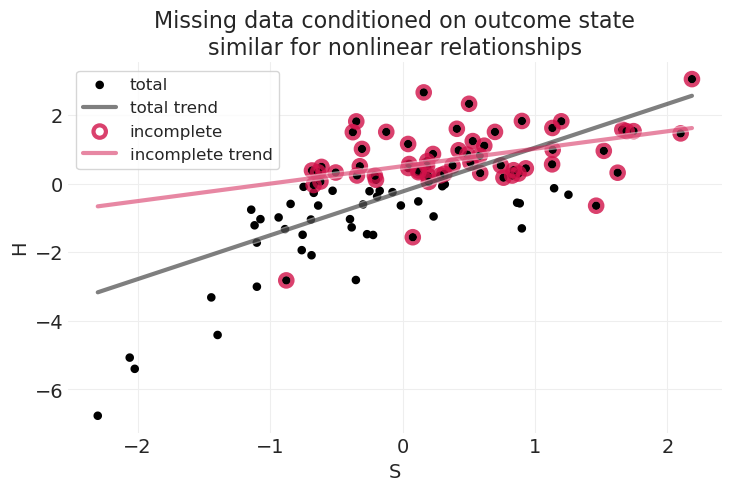

In [10]:
np.random.seed(1)
n_homework = 100
# Student knowledge
S = stats.norm.rvs(size=n_homework)

# Nonlinear association between student ability and homework score
mu_score = 1 - np.exp(-0.9 * S)
H = stats.norm.rvs(mu_score)

# Dog eats 90% of homework that is below average
p_dog_eats_homework = np.where(H < 0, 0.9, 0)
D = stats.bernoulli.rvs(p=p_dog_eats_homework)
Hstar = H.copy()
Hstar[D==1] = np.nan

plot_dog_homework(S, H, Hstar, title="Missing data conditioned on outcome state\nsimilar for nonlinear relationships")

- without knowing the causal relationship between the state and the data loss, and the functional forms of how $S$ is associated with $H$, it's difficult to account for this scenario

## Stereotypical cases

1. Data loss is **random and indpendent of causes**
   - "Dog eats homework randomly"
   - Dropping complete cases ok, but lose efficiency
3. Data loss is **conditioned on the cause**
   - "Dog eats homework based on the student's study habits"
   - Need to correctly condition on cause
5. Data loss is **conditioned on the outcome**
   - "Dog eats homeowork based on the score of the homework"
   - This is usually hopeless unless we can model the causal process of how state affects data loss (i.e. the dog's behavior in this simulation)
     - e.g. survival analysis and censored data

## Bayesian Imputation

- Works for **Stereotypical cases** 1), 2) and subsets of 3) (e.g. survival analysis)
- Having a joint (Bayesian) model for all variables (observed data and parameters) provides a means for inferring reasonable bounds on the values that are missing

### Imputing or Marginalizing
- **Imputation**: compute a posterior probability distribution of the missing values
  - usually involves partial pooling
  - we've already done this to some extent with the missing district in the Bangladesh dataset
- **Marginalizing unknowns**: average over the distribution of missing values using the posteriors for the other variables
  - no need to calculate posteriors for missing values

#### When to impute? When to marginalize?
- Sometimes imputation is unnecessary -- e.g. discrete variables
  - Marginalization works here
- It's sometimes easier to impute
  - e.g. when the data loss process is well understood as in censoring in survival analysis
  - marginalization may be difficult for more exotic models


# Revisiting Phylogenetic Regression

In [11]:
PRIMATES301 = utils.load_data("Primates301")
PRIMATES301.head()

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.00,40.0,NaN,106.15,276.0,NaN,NaN
1,Allocebus_trichotis,Allocebus,trichotis,NaN,2,2,0.0,6.0,NaN,78.09,1.0,NaN,NaN,NaN,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.00,7.4,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.00,8.9,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.00,7.4,NaN,NaN,NaN,NaN,NaN


- 301 Primate profiles
- Life history traits
  - Body Mass $M$
  - Brain size $B$
  - Social Group Size $G$
- Issues
  - Lots of **missing data**
    - Complete case analysis only includes 151 observations
  - measurement error
  - unobserved confounding
 
## Imputing Primates

- **Key Idea**: missing values have probability distributions
  - Express a causal model for each partially-observed variable
  - Replace each missing value with a parameter, and let the model proceed as normal
    - Duality of parameters and data:
      - In Bayes there is no distinction between params and data: missing value is just a parameter, observed value is data
  - e.g. one variable that _is_ available can inform us of reasonable values for missing variable associated with the observation
- **Conceptually weired, technically awkward**

#### Revisiting previous causal model

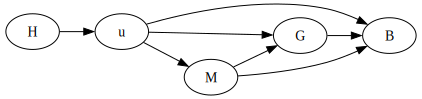

In [12]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "B"),
        ("M", "G"),
        ("u", "M"),
        ("u", "G"),
        ("u", "B"),
        ("H", "u")
    ],
    graph_direction="LR"
)

- where $M,G,B$ are defined above
- shared history $H$, which leads to
- historical-based confounds $u$, which we try to capture with a phylogeny

#### Let's now include how missing values may occur

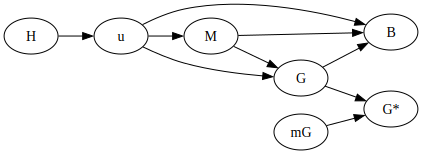

In [13]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "B"),
        ("M", "G"),
        ("u", "M"),
        ("u", "G"),
        ("u", "B"),
        ("H", "u"),
        ("G", "G*"),
        ("mG", "G*")
    ],
    graph_direction="LR"
)

- We observe group size $G^*$, which has missing values for some observations/species
- What influences the cause of missingness $m_G$?
  - often the assumption is that it's totally random, but this is highly unlikely
  - there are **many possible ways that missingness could occur**.


#### Some hypotheses on what causes missing data...

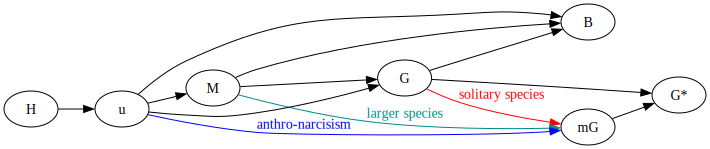

In [14]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "B"),
        ("M", "G"),
        ("u", "M"),
        ("u", "G"),
        ("u", "B"),
        ("H", "u"),
        ("G", "G*"),
        ("mG", "G*"),
        ("M", "mG"),
        ("u", "mG"),
        ("G", "mG")
    ],
    edge_props={
        ("u", "mG"): {"color": "blue", "fontcolor": "blue", "label": "anthro-narcisism"},
        ("M", "mG"): {"color": "darkcyan", "fontcolor": "darkcyan", "label": "larger species"},
        ("G", "mG"): {"color": "red", "fontcolor": "red", "label": "solitary species"}
    },
    graph_direction="LR"
)

- All the colored arrows, and assumptions/hypotheses, are potentially in play
  - <span style="color:blue">**anthro-narcisism**: humans are more likely to study primates that are like them</span>
  - <span style="color:darkcyan">**larger species** with larger body mass easier to count: e.g. some species might live in trees and are harder to observe</span>
  - <span style="color:red">some species have little or no social group; these **solitary species** are difficult to observe and gather data on</span>
- Whatever the assumption, the goal is to **use causal model to infer the probability distribution of each missing value**
- Uncertainty in each missing value will cascade through the model
  - again, no need to be clever
  - trust the axioms of probability

## Modeling missing data for multiple variables simultaneously

### $M, G, B$ all have missing values $M^*, G^*, B^*$

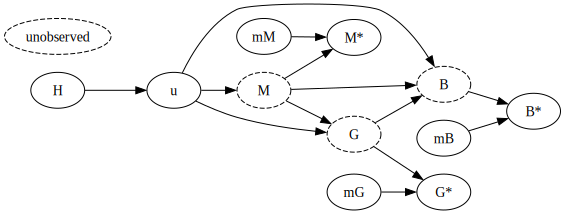

In [15]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "G"),
        ("M", "B"),
        ("G", "B"),
        ("M", "M*"),
        ("G", "G*"),
        ("B", "B*"),
        ("mM", "M*"),
        ("mB", "B*"),
        ("mG", "G*"),
        ("H", "u"),
        ("u", "G"),
        ("u", "M"),
        ("u", "B"),
    ],
    node_props={
        "G": {"style": "dashed"},
        "M": {"style": "dashed"},
        "B": {"style": "dashed"},
        "unobserved": {"style": "dashed"}
    },
    graph_direction="LR"
)

### Dealing with missing values in Brain Size $B$

It turns out we already handled this using Gaussian processes in the original Phylogenetic Regression example. By leveraging local pooling offered by the Gaussian process, we fill in missing brain size $B$ values using information from species that are similar those species with missing values, but _do_ have values for $B$.

The equivalent causal-sub-graph used to modele Brain Size in the "Phylogenetic Regression" section of [Lecture 16 - Gaussian Processes](<Lecture 16 - Gaussian Processes.ipynb>)

#### Brain Size $B$ Model

Assuming missingness is totally at random

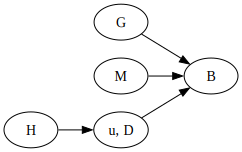

In [16]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "B"),
        ("M", "B"),
        ("u, D", "B"),
        ("H", "u, D")
    ],
    graph_direction="LR"
)


$$
\begin{align}
    \textbf{B} &\sim \text{MVNormal}(\mu_B, \textbf{K}_B) \\
    \mu_{B,i} &= \alpha_B + \beta_{GB} G_i + \beta_{MB} M_i \\
    \mathbf{K}_B &= \eta_B^2 \exp(-\rho_B D_{jk})\\
    \alpha_B &\sim \text{Normal}(0, 1) \\
    \beta_{GB, MB} &\sim \text{Normal}(0, 1) \\
    \eta_B^2 &\sim \text{HalfNormal}(1, 0.25)\\
    \rho_B &\sim \text{HalfNormal}(3, 0.25)
\end{align}
$$

We can use a simular approach to simultaneously formulate parallel models for the other variables $G,M$ that may have missing values, a' la Full Luxury Bayes.


#### Group Size $G$ Model

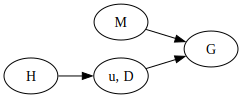

In [17]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "G"),
        ("u, D", "G"),
        ("H", "u, D")
    ],
    graph_direction="LR"
)


$$
\begin{align}
    \textbf{G} &\sim \text{MVNormal}(\mu_G, \textbf{K}_G) \\
    \mu_{G,i} &= \alpha_G + \beta_{MG} M_i \\
    \mathbf{K}_G &= \eta_G^2 \exp(-\rho_G D_{jk})\\
    \alpha_G &\sim \text{Normal}(0, 1) \\
    \beta_{MG} &\sim \text{Normal}(0, 1) \\
    \eta_G^2 &\sim \text{HalfNormal}(1, 0.25)\\
    \rho_G &\sim \text{HalfNormal}(3, 0.25)
\end{align}
$$


#### Body Mass $M$ model

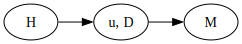

In [18]:
utils.draw_causal_graph(
    edge_list=[
        ("u, D", "M"),
        ("H", "u, D")
    ],
    graph_direction="LR"
)

$$
\begin{align}
    \textbf{M} &\sim \text{MVNormal}(\mathbf{0}, \textbf{K}_M) \\
    \mathbf{K}_M &= \eta_M^2 \exp(-\rho_M D_{jk})\\
    \eta_M^2 &\sim \text{HalfNormal}(1, 0.25)\\
    \rho_M &\sim \text{HalfNormal}(3, 0.25)
\end{align}
$$

## Drawing the missing owl 🦉

Building a model containing three simultaneous Gaussian processes has a lot of working parts. It's better to build up model complexity in small steps.

1. Ignore cases with missing $B$ values (for now)
   - $B$ is the outcome, so any imputation would just be prediction
2. Impute $G,M$ ignoring models for each
   - wrong model, correct process
   - allows us to see the consequences of adding complexity to model 
3. Impute $G$ using a $G$-specific submodel
4. Impute $B,G,M$ using a submodel for each  

### 1. Ignore cases with missing $B$ values

#### Filter out observations missing brain volume measurments

In [19]:
PRIMATES = PRIMATES301[PRIMATES301.brain.notna()]
PRIMATES

,name,genus,species,subspecies,spp_id,genus_id,social_learning,research_effort,brain,body,group_size,gestation,weaning,longevity,sex_maturity,maternal_investment
0,Allenopithecus_nigroviridis,Allenopithecus,nigroviridis,NaN,1,1,0.0,6.0,58.02,4655.0,40.00,NaN,106.15,276.0,NaN,NaN
2,Alouatta_belzebul,Alouatta,belzebul,NaN,3,3,0.0,15.0,52.84,6395.0,7.40,NaN,NaN,NaN,NaN,NaN
3,Alouatta_caraya,Alouatta,caraya,NaN,4,3,0.0,45.0,52.63,5383.0,8.90,185.92,323.16,243.6,1276.72,509.08
4,Alouatta_guariba,Alouatta,guariba,NaN,5,3,0.0,37.0,51.70,5175.0,7.40,NaN,NaN,NaN,NaN,NaN
5,Alouatta_palliata,Alouatta,palliata,NaN,6,3,3.0,79.0,49.88,6250.0,13.10,185.42,495.60,300.0,1578.42,681.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Trachypithecus_phayrei,Trachypithecus,phayrei,NaN,296,67,0.0,16.0,72.84,7475.0,12.90,180.61,305.87,NaN,NaN,486.48
296,Trachypithecus_pileatus,Trachypithecus,pileatus,NaN,297,67,0.0,5.0,103.64,11794.0,8.50,NaN,NaN,NaN,NaN,NaN
298,Trachypithecus_vetulus,Trachypithecus,vetulus,NaN,299,67,0.0,2.0,61.29,6237.0,8.35,204.72,245.78,276.0,1113.70,450.50
299,Varecia_rubra,Varecia,rubra,NaN,300,68,NaN,NaN,31.08,3470.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Cross-tabulate missingess for $G,M$ on the resulting dataset

In [20]:
 PRIMATES.group_size.isna().sum()

33

In [21]:
print("Pattern of missingness:\n")
print(utils.crosstab(PRIMATES.body.notna(), PRIMATES.group_size.notna()))
print(f"\nCorrelation of missing values: {np.corrcoef(PRIMATES.body.isna(), PRIMATES.group_size.isna())[0][1]:0.2}")

Pattern of missingness:

group_size  False  True 
body                    
False           2      0
True           31    151

Correlation of missing values: 0.22


- True: Observed
- False: Missing
- Group size $G$ missing a lot of values (33)
- Some correlation between the presence/absence of each variable

### 2. Impute $G,M$ naively, ignoring models for each

Idea here is to treat $G, M$ as independent random variables with no causes, e.g. standard Normals.

$$
M_i, G_i \sim \text{Normal}(0, 1) \\
$$

- This is not the correct model, but the correct starting place to build up the model gradually
- Interpretation:
  - When $G_i$ is observed, the distribution is the likelihood for a standardized variable
  - When $G_i$ is missing, the distribution is the prior for the "parameter"

#### Fit the impuatation model that ignores the submodels for $G,M$
##### Load the phlogenetic distance matrix

In [22]:
PRIMATES_DISTANCE_MATRIX = utils.load_data("primates301_distance_matrix").values

# Filter out cases without $B$ values from the raw distance matrix
PRIMATES_DISTANCE_MATRIX = PRIMATES_DISTANCE_MATRIX[PRIMATES.index][:, PRIMATES.index]

# Rescale distances
D_mat = (PRIMATES_DISTANCE_MATRIX / PRIMATES_DISTANCE_MATRIX.max())
assert D_mat.max() == 1

In [23]:
# Preprocess the data
G_obs = utils.standardize(np.log(PRIMATES.group_size.values))
N_G_missing = np.isnan(G_obs).sum()
M_obs = utils.standardize(np.log(PRIMATES.body.values))
N_M_missing = np.isnan(M_obs).sum()
B_obs = utils.standardize(np.log(PRIMATES.brain.values))
N_obs = len(B_obs)

#### Fit the naive imputation model

Below is an implementation that uses PyMC's Gaussian process module.

In [24]:
PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'], sort=False) 
coords = {'primate': PRIMATE}

class MeanBodyMassSocialGroupSize(pm.gp.mean.Linear):
    """
    Custom mean function that separates Social Group Size and
    Body Mass effects from phylogeny
    """
    def __init__(self, alpha, beta_G, beta_M, G, M):
        self.alpha = alpha
        self.beta_G = beta_G
        self.beta_M = beta_M
        self.G = G
        self.M = M

    def __call__(self, X):
        return self.alpha + self.beta_G * self.G + self.beta_M * self.M

# with pm.Model(coords=coords) as naive_imputation_model:
    
#     # Priors
#     alpha = pm.Normal("alpha", 0, 1)
#     beta_G = pm.Normal("beta_G", 0, 0.5)
#     beta_M = pm.Normal("beta_M", 0, 0.5)
#     sigma = pm.Exponential("sigma", 1)

#     # Naive imputation for G, M
#     G = pm.Normal("G", 0, 1, observed=G_obs, dims='primate')
#     M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')
    
#     mean_func = MeanBodyMassSocialGroupSize(alpha, beta_G, beta_M, G, M)

#     # Phylogenetic distance covariance prior, L1-kernel function
#     eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.01)
#     rho = pm.TruncatedNormal("rho", 3, .25, lower=.01)
#     cov_func = eta_squared * pm.gp.cov.Exponential(1, ls=rho)

#     gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
#     gp.marginal_likelihood("B", X=D_mat, y=B_obs, noise=sigma)
    
#     naive_imputation_inference = pm.sample(cores=1)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from the lecture.

In [25]:
def generate_L1_kernel_matrix(D, eta_squared, rho, smoothing=0.01):
    K = eta_squared * pm.math.exp(-rho * D)
    # Smooth the diagonal of the covariance matrix
    N = D.shape[0]
    K += np.eye(N) * smoothing
    return K

coords = {'primate': PRIMATES['name'].values}
with pm.Model(coords=coords) as naive_imputation_model:
    
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_G = pm.Normal("beta_G", 0, 0.5)
    beta_M = pm.Normal("beta_M", 0, 0.5)

    # Phylogenetic distance covariance prior, L1-kernel function
    eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.001)
    rho = pm.TruncatedNormal("rho", 3, .25, lower=.001)
    # K = pm.Deterministic('K', generate_L1_kernel_matrix(D_mat, eta_squared, rho))
    K = pm.Deterministic('K', eta_squared * pm.math.exp(-rho * D_mat))

    # Naive imputation for G, M
    G = pm.Normal("G", 0, 1, observed=G_obs, dims='primate')
    M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')

    # Likelihood for B
    mu = alpha + beta_G * G + beta_M * M
    pm.MvNormal("B", mu=mu, cov=K, observed=B_obs)
    
    naive_imputation_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_G, beta_M, eta_squared, rho, G_unobserved, M_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


#### Demonstrate the effect of imputation
##### $M$ Imputation

In [26]:
# Now all $M$ have imputed values
az.summary(naive_imputation_inference, var_names=['M'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M[Allenopithecus_nigroviridis],0.335,0.0,0.335,0.335,0.0,0.0,4000.0,4000.0,NaN
M[Alouatta_belzebul],0.542,0.0,0.542,0.542,0.0,0.0,4000.0,4000.0,NaN
M[Alouatta_caraya],0.430,0.0,0.430,0.430,0.0,0.0,4000.0,4000.0,NaN
M[Alouatta_guariba],0.404,0.0,0.404,0.404,0.0,0.0,4000.0,4000.0,NaN
M[Alouatta_palliata],0.527,0.0,0.527,0.527,0.0,0.0,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
M[Trachypithecus_phayrei],0.643,0.0,0.643,0.643,0.0,0.0,4000.0,4000.0,NaN
M[Trachypithecus_pileatus],0.940,0.0,0.940,0.940,0.0,0.0,4000.0,4000.0,NaN
M[Trachypithecus_vetulus],0.526,0.0,0.526,0.526,0.0,0.0,4000.0,4000.0,NaN
M[Varecia_rubra],0.144,0.0,0.144,0.144,0.0,0.0,4000.0,4000.0,NaN


##### Prior values for $M$

In [27]:
print("Number of missing M values:", N_M_missing)
az.summary(naive_imputation_inference, var_names=['M_unobserved'])

Number of missing M values: 2


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M_unobserved[0],-1.682,0.226,-2.128,-1.279,0.002,0.002,9211.0,2758.0,1.0
M_unobserved[1],-0.738,0.097,-0.915,-0.551,0.001,0.001,7713.0,3191.0,1.0


##### $G$ Imputation

In [28]:
# Now all $G$ have imputed values
az.summary(naive_imputation_inference, var_names=['G'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
G[Allenopithecus_nigroviridis],1.402,0.000,1.402,1.402,0.00,0.000,4000.0,4000.0,NaN
G[Alouatta_belzebul],0.003,0.000,0.003,0.003,0.00,0.000,4000.0,4000.0,NaN
G[Alouatta_caraya],0.156,0.000,0.156,0.156,0.00,0.000,4000.0,4000.0,NaN
G[Alouatta_guariba],0.003,0.000,0.003,0.003,0.00,0.000,4000.0,4000.0,NaN
G[Alouatta_palliata],0.477,0.000,0.477,0.477,0.00,0.000,4000.0,4000.0,NaN
...,...,...,...,...,...,...,...,...,...
G[Trachypithecus_phayrei],0.464,0.000,0.464,0.464,0.00,0.000,4000.0,4000.0,NaN
G[Trachypithecus_pileatus],0.118,0.000,0.118,0.118,0.00,0.000,4000.0,4000.0,NaN
G[Trachypithecus_vetulus],0.103,0.000,0.103,0.103,0.00,0.000,4000.0,4000.0,NaN
G[Varecia_rubra],0.037,0.989,-1.898,1.816,0.01,0.017,9529.0,2944.0,1.0


##### Prior Values for $G$

In [29]:
print("Number of missing G values:", N_G_missing)
az.summary(naive_imputation_inference, var_names=['G_unobserved'])

Number of missing G values: 33


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
G_unobserved[0],-0.212,0.993,-2.117,1.588,0.011,0.016,8125.0,2903.0,1.00
G_unobserved[1],-0.004,1.005,-1.808,1.956,0.010,0.019,9791.0,2778.0,1.00
G_unobserved[2],-0.014,1.005,-1.843,1.871,0.011,0.017,8133.0,3014.0,1.00
G_unobserved[3],-0.110,1.005,-2.121,1.705,0.010,0.018,9964.0,2837.0,1.00
G_unobserved[4],-0.064,0.998,-1.882,1.850,0.011,0.019,8122.0,2688.0,1.00
G_unobserved[5],0.024,0.970,-1.824,1.822,0.011,0.017,7901.0,3108.0,1.00
G_unobserved[6],-0.005,1.007,-1.987,1.759,0.010,0.017,9309.0,3088.0,1.00
G_unobserved[7],-0.018,1.012,-1.968,1.792,0.010,0.018,9734.0,3032.0,1.00
G_unobserved[8],-0.053,1.016,-1.912,1.849,0.010,0.018,9823.0,3009.0,1.00
G_unobserved[9],-0.022,0.972,-1.915,1.731,0.011,0.016,8041.0,3351.0,1.00


#### Plot posterior imputation

In [30]:
def plot_posterior_imputation(xvar, yvar, inference, impute_color='C0', impute_x=False, impute_y=False, title=None):
    plot_data = pd.DataFrame(
        {
            "G": G_obs,
            "M": M_obs,
            "B": B_obs
        }
    )
    # Plot observed
    utils.plot_scatter(
        plot_data[xvar],
        plot_data[yvar],
        color='k',
        label='observed'
    )

    # Get and plot imputed
    impute_x_values = None
    impute_y_values = None
    if impute_x and f"{xvar}_unobserved" in inference.posterior:
        x_impute_idx = plot_data[plot_data[xvar].isnull()].index.values
        impute_x_values = az.summary(inference, var_names=[f"{xvar}_unobserved"])['mean'].values

    if impute_y and f"{yvar}_unobserved" in inference.posterior:
        y_impute_idx = plot_data[plot_data[yvar].isnull()].index.values
        impute_y_values = az.summary(inference, var_names=[f"{yvar}_unobserved"])['mean'].values

    if impute_x_values is None:
        impute_x_values = plot_data.loc[y_impute_idx, xvar].values

    if impute_y_values is None:
        impute_y_values = plot_data.loc[x_impute_idx, yvar].values

    utils.plot_scatter(
        impute_x_values,
        impute_y_values,
        color=impute_color,
        label='imputed',
        alpha=1,
        s=100
    )
        
    plt.xlabel(f"${xvar}$ (standardized)")
    plt.ylabel(f"${yvar}$ (standardized)")
    plt.legend()
    plt.title(title)

#### Looking at imputed values

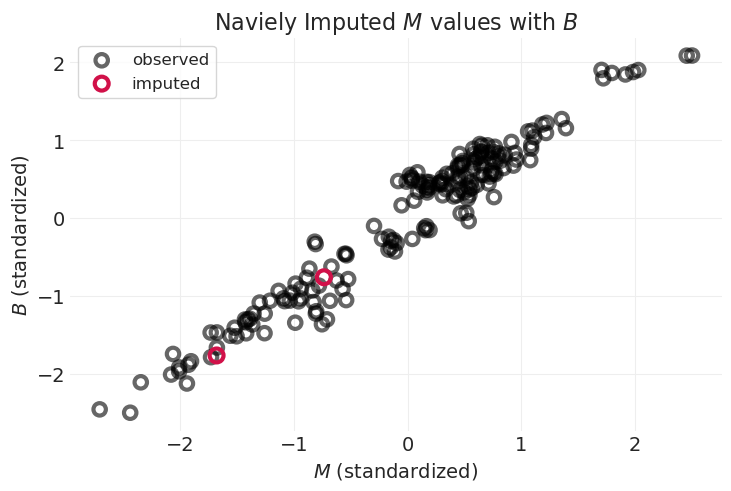

In [31]:
plot_posterior_imputation("M", "B", naive_imputation_inference, impute_x=True, title="Naviely Imputed $M$ values with $B$")

- Because $M$ is strongly associated with $B$, the imputed $M$ values follow the linear relationship

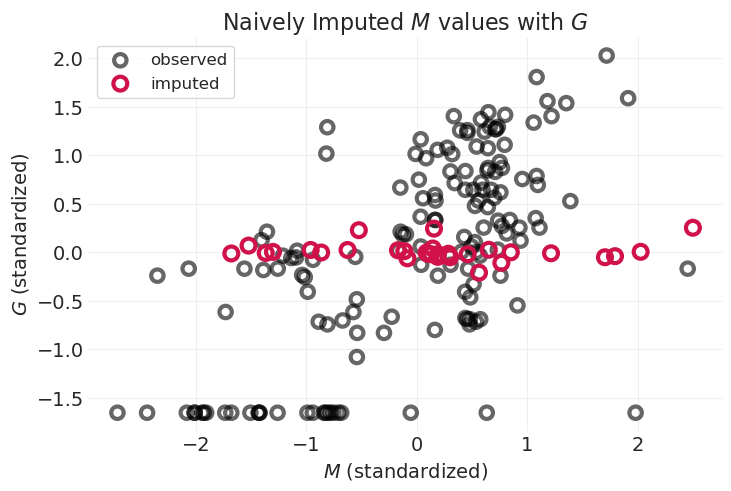

In [32]:
plot_posterior_imputation("M", "G", naive_imputation_inference, impute_y=True, title="Naively Imputed $M$ values with $G$")


- Because the association between $M$ and $G$ isn't modeled, imputed values doesn't follow the linear trend between $M$ and $G$
- We've left some information on the table; this is the result of ignoring the full generative model

### Complete case model for comparison

Here we'll fit a complet-cases-only model where there's no need for imputation, but we throw away data.

In [33]:
# Complete Case
PRIMATES_CC = PRIMATES301.query(
    "brain.notnull() and body.notnull() and group_size.notnull()",
    engine='python'
)

G_CC = utils.standardize(np.log(PRIMATES_CC.group_size.values))
M_CC = utils.standardize(np.log(PRIMATES_CC.body.values))
B_CC = utils.standardize(np.log(PRIMATES_CC.brain.values))

# Get complete case distance matrix
PRIMATES_DISTANCE_MATRIX_CC = utils.load_data("primates301_distance_matrix").values

# Filter out incomplete cases
PRIMATES_DISTANCE_MATRIX_CC  = PRIMATES_DISTANCE_MATRIX_CC[PRIMATES_CC.index][:, PRIMATES_CC.index]

# Rescale distances to [0, 1]
D_mat_CC = (PRIMATES_DISTANCE_MATRIX_CC / PRIMATES_DISTANCE_MATRIX_CC.max())
assert D_mat_CC.max() == 1

Below is an implementation that uses PyMC's Gaussian process module.

In [34]:
# with pm.Model() as complete_case_model:
    
#     # Priors
#     alpha = pm.Normal("alpha", 0, 1)
#     beta_G = pm.Normal("beta_GB", 0, 0.5)
#     beta_M = pm.Normal("beta_MB", 0, 0.5)
#     sigma = pm.Exponential("sigma", 1)

#     # Phylogenetic distance covariance
#     mean_func = MeanBodyMassSocialGroupSize(alpha, beta_G, beta_M, G_CC, M_CC)

#     # Phylogenetic distance covariance prior, L1-kernel function
#     eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.01)
#     rho = pm.TruncatedNormal("rho", 3, .25, lower=.01)
#     cov_func = eta_squared * pm.gp.cov.Exponential(1, ls=rho)

#     gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
#     gp.marginal_likelihood("B", X=D_mat_CC, y=B_CC, noise=sigma)

#     complete_case_inference = pm.sample(target_accept=.95)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from the lecture.

In [35]:
with pm.Model() as complete_case_model:
    
    # Priors
    alpha = pm.Normal("alpha", 0, 1)
    beta_G = pm.Normal("beta_G", 0, 0.5)
    beta_M = pm.Normal("beta_M", 0, 0.5)

    # Phylogenetic distance covariance
    eta_squared = pm.TruncatedNormal("eta_squared", 1, .25, lower=.001)
    rho = pm.TruncatedNormal("rho", 3, .25, lower=.001)

    K = pm.Deterministic('K', generate_L1_kernel_matrix(D_mat_CC, eta_squared, rho, smoothing=.001))
    # K = pm.Deterministic('K', eta_squared * pm.math.exp(-rho * D_mat_CC))

    # Likelihood
    mu = alpha + beta_G * G_CC + beta_M * M_CC
    pm.MvNormal("B", mu=mu, cov=K, observed=B_CC)
    complete_case_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_G, beta_M, eta_squared, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


### Compare posteriors for naively-imputed and complete case model

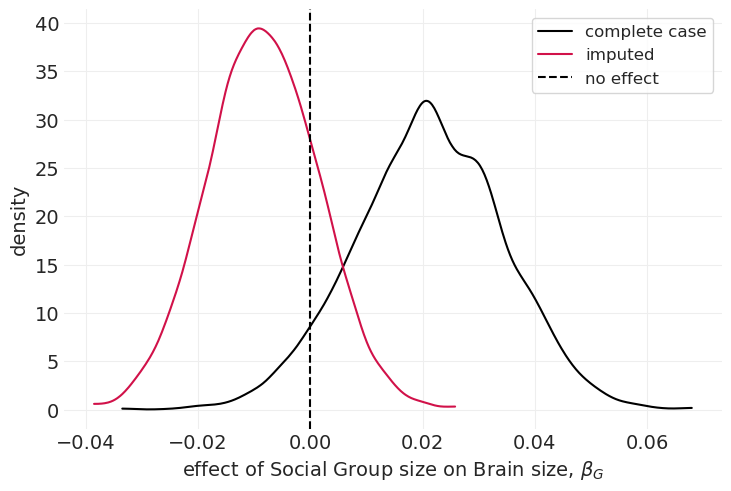

In [36]:
az.plot_dist(complete_case_inference.posterior['beta_G'], label='complete case', color='k')
az.plot_dist(naive_imputation_inference.posterior['beta_G'], label='imputed', color='C0')
plt.axvline(0, linestyle='--', color='k', label='no effect')
plt.xlabel("effect of Social Group size on Brain size, $\\beta_G$")
plt.ylabel("density")
plt.legend();

- we can see that the posterior for the imputed model attenuates the effect of Group size on Brain Size

### 3. Impute $G$ using a $G$-specific submodels

Add the generative model for Group Size. But, again, we'll do this in baby steps, slowly building complexity

1) Model that only models effect of body mass on group size $M \rightarrow G$
2) Model that only includes Social group phylogentic interactions
3) Model that combines phylogeny and $M \rightarrow G$

#### 1. Model that only models effect of body mass on group size $M \rightarrow G$

Below is an implementation that uses PyMC's Gaussian process module.

In [37]:
# PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'].values)
# coords = {'primate': PRIMATE}

# with pm.Model(coords=coords) as G_body_mass_model:
    
#     # Priors
#     alpha_G = pm.Normal("alpha_G", 0, 1)
#     beta_MG = pm.Normal("beta_MG", 0, 0.5)
#     sigma_G = pm.Exponential("sigma_G", 1)
    
#     alpha_B = pm.Normal("alpha_B", 0, 1)
#     beta_GB = pm.Normal("beta_GB", 0, 0.5)
#     beta_MB = pm.Normal("beta_MB", 0, 0.5)
#     sigma_B = pm.Exponential("sigma_B", 1)

#     # Naive imputation for M
#     M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')

#     # G model M->G (performs imputation)
#     mu_G = alpha_G + beta_MG * M
#     G = pm.Normal("G", mu_G, sigma_G, observed=G_obs)

#     # B Model
#     eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.01)
#     rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.01)
#     cov_func_B = eta_squared_B * pm.gp.cov.Exponential(1, ls=rho_B)
#     mean_func_B = MeanBodyMassSocialGroupSize(alpha_B, beta_GB, beta_MB, G, M)

#     # Gaussian Process
#     gp_B = pm.gp.Marginal(mean_func=mean_func_B, cov_func=cov_func_B)
#     gp_B.marginal_likelihood("B", X=D_mat, y=B_obs, noise=sigma_B)
    
#     G_body_mass_inference = pm.sample(target_accept=.95, cores=1)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from the lecture.

In [38]:
PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'].values)
coords = {'primate': PRIMATE}

with pm.Model(coords=coords) as G_body_mass_model:
    
    # Priors
    alpha_B = pm.Normal("alpha_B", 0, 1)
    beta_GB = pm.Normal("beta_GB", 0, 0.5)
    beta_MB = pm.Normal("beta_MB", 0, 0.5)

    alpha_G = pm.Normal("alpha_G", 0, 1)
    beta_MG = pm.Normal("beta_MG", 0, 0.5)
    sigma_G = pm.Exponential("sigma_G", 1)

    # Naive imputation for M
    M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')
    
    # Body-mass only, no interactions
    mu_G = alpha_G + beta_MG * M
    G = pm.Normal("G", mu_G, sigma_G, observed=G_obs)

    # B Model
    eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.001)
    rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.001)
    K_B = pm.Deterministic('K_B', eta_squared_B * pm.math.exp(-rho_B * D_mat))

    # Likelihood for B
    mu_B = alpha_B + beta_GB * G + beta_MB * M
    pm.MvNormal("B", mu=mu_B, cov=K_B, observed=B_obs)
    
    G_body_mass_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_B, beta_GB, beta_MB, alpha_G, beta_MG, sigma_G, M_unobserved, G_unobserved, eta_squared_B, rho_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.


##### Look at $M \rightarrow G$-only imputation

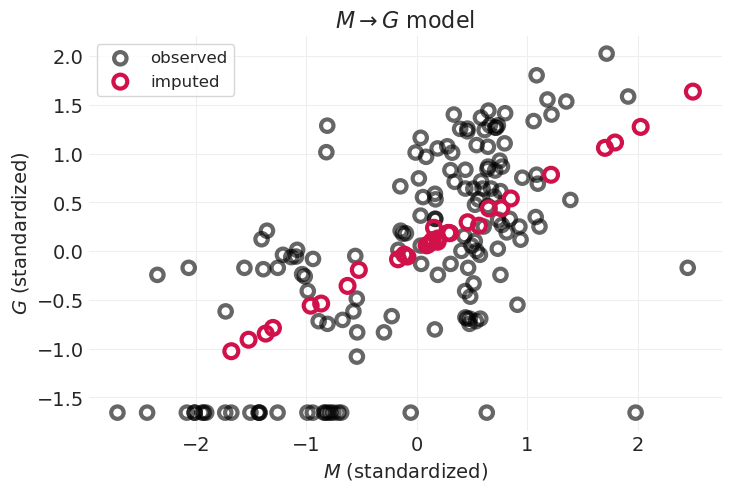

In [39]:
plot_posterior_imputation("M", "G", G_body_mass_inference, impute_y=True, title="$M \\rightarrow G$ model")

- By modeling the effect of $M$ on $G$, we're able to capture the linear trend for; imputed variables lie along this trend
- However, by ignoring phylogenetic similarity, we aren't able to capture nonlinearities in the data
  - e.g. some species with small group size lying along the lower left of the plot do not follow the linear trend

#### 2. Model that only includes Social group phylogentic interactions

Below is an implementation that uses PyMC's Gaussian process module.

In [40]:
# PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'].values)
# coords = {'primate': PRIMATE}

# with pm.Model(coords=coords) as G_phylogeny_model:
    
#     # Priors
#     alpha_G = pm.Normal("alpha_G", 0, 1)
#     sigma_G = pm.Exponential("sigma_G", 1)
    
#     alpha_B = pm.Normal("alpha_B", 0, 1)
#     beta_GB = pm.Normal("beta_GB", 0, 0.5)
#     beta_MB = pm.Normal("beta_MB", 0, 0.5)
#     sigma_B = pm.Exponential("sigma_B", 1)

#     # Naive imputation for M
#     M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')

#     # G model, interactions only
#     mean_func_G = MeanBodyMassSocialGroupSize(alpha_G, 0, 0, 0, 0)

#     eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.01)
#     rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.01)
#     cov_func_G = eta_squared_G * pm.gp.cov.Exponential(1, ls=rho_G)

#     gp_G = pm.gp.Marginal(mean_func=mean_func_G, cov_func=cov_func_G)
#     G = gp_G.marginal_likelihood("G", X=D_mat, y=G_obs, noise=sigma_G)

#     # B Model
#     mean_func_B = MeanBodyMassSocialGroupSize(alpha_B, beta_GB, beta_MB, G, M)

#     eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.01)
#     rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.01)
#     cov_func_B = eta_squared_B * pm.gp.cov.Exponential(1, ls=rho_B)

#     gp_B = pm.gp.Marginal(mean_func=mean_func_B, cov_func=cov_func_B)
#     gp_B.marginal_likelihood("B", X=D_mat, y=B_obs, noise=sigma_B)
    
#     G_phylogeny_inference = pm.sample(target_accept=.95, cores=1)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from lecture.

In [41]:
coords = {'primate': PRIMATES['name'].values}
with pm.Model(coords=coords) as G_phylogeny_model:
    
    # Priors
    alpha_B = pm.Normal("alpha_B", 0, 1)
    beta_GB = pm.Normal("beta_GB", 0, 0.5)
    beta_MB = pm.Normal("beta_MB", 0, 0.5)

    alpha_G = pm.Normal("alpha_G", 0, 1)
    beta_MG = pm.Normal("beta_MG", 0, 0.5)

    # Naive imputation for M
    M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')
    
    # G Model Imputation, only phylogenetic interaction
    eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.001)
    rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.001)
    K_G = pm.Deterministic('K_G', eta_squared_G * pm.math.exp(-rho_G * D_mat))
    
    mu_G = pm.math.zeros_like(B_obs)  # no linear model 
    G = pm.MvNormal("G", mu=mu_G, cov=K_G, observed=G_obs)

    # B Model
    eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.001)
    rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.001)
    K_B = pm.Deterministic('K_B', eta_squared_B * pm.math.exp(-rho_B * D_mat))

    # Likelihood for B
    mu_B = alpha_B + beta_GB * G + beta_MB * M
    pm.MvNormal("B", mu=mu_B, cov=K_B, observed=B_obs)
    
    G_phylogeny_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_B, beta_GB, beta_MB, alpha_G, beta_MG, M_unobserved, eta_squared_G, rho_G, G_unobserved, eta_squared_B, rho_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.


##### Look at phylogeny-only imputation

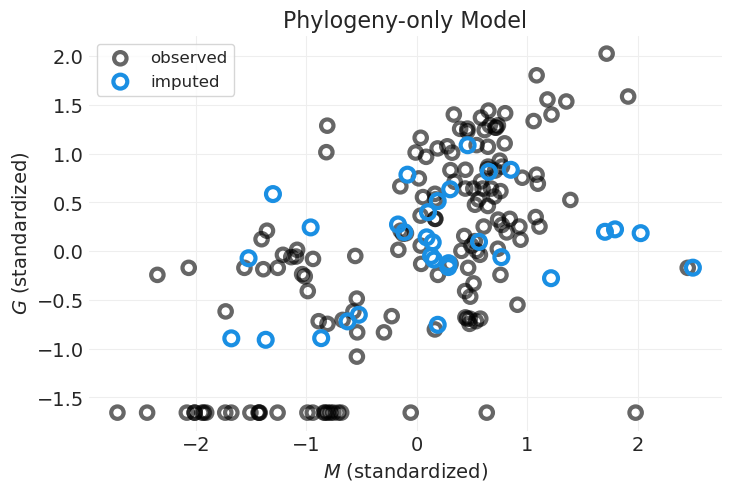

In [42]:
plot_posterior_imputation(
    "M", "G",
    G_phylogeny_inference,
    impute_y=True,
    impute_color='C1',
    title="Phylogeny-only Model"
)


⚠️ for some reason, after trying two different implementation of GPs using PyMCs `gp` module, as well as using `MVNormal` likelihood (both give similar results), I'm not able to replicate the imputation for solo primates presented in lecture. 

**Comments and suggestions are welcome on what I may be doing incorrectly here**

#### 3. Fit model that combines phylogeny and $M \rightarrow G$

Below is an implementation that implements the model using PyMC's Gaussian process module.

In [43]:
# PRIMATE_ID, PRIMATE = pd.factorize(PRIMATES['name'].values)
# coords = {'primate': PRIMATE}

# with pm.Model(coords=coords) as G_imputation_model:
    
#     # Priors
#     alpha_G = pm.Normal("alpha_G", 0, 1)
#     beta_MG = pm.Normal("beta_MG", 0, 1)
#     sigma_G = pm.Exponential("sigma_G", 1)
    
#     alpha_B = pm.Normal("alpha_B", 0, 1)
#     beta_GB = pm.Normal("beta_GB", 0, 0.5)
#     beta_MB = pm.Normal("beta_MB", 0, 0.5)
#     sigma_B = pm.Exponential("sigma_B", 1)

#     # Naive imputation for M
#     M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')

#     # G model, interactions only
#     mean_func_G = MeanBodyMassSocialGroupSize(alpha_G, 0, beta_MG, 0, M)

#     eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.01)
#     rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.01)
#     cov_func_G = eta_squared_G * pm.gp.cov.Exponential(1, ls=rho_G)

#     gp_G = pm.gp.Marginal(mean_func=mean_func_G, cov_func=cov_func_G)
#     G = gp_G.marginal_likelihood("G", X=D_mat, y=G_obs, noise=sigma_G)

#     # B Model
#     mean_func_B = MeanBodyMassSocialGroupSize(alpha_B, beta_GB, beta_MB, G, M)

#     eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.01)
#     rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.01)
#     cov_func_B = eta_squared_B * pm.gp.cov.Exponential(1, ls=rho_B)

#     gp_B = pm.gp.Marginal(mean_func=mean_func_B, cov_func=cov_func_B)
#     gp_B.marginal_likelihood("B", X=D_mat, y=B_obs, noise=sigma_B)
    
#     G_imputation_inference = pm.sample(target_accept=.95, cores=1)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from lecture.

In [44]:
coords = {'primate': PRIMATES['name'].values}
with pm.Model(coords=coords) as G_imputation_model:
    
    # Priors
    alpha_B = pm.Normal("alpha_B", 0, 1)
    beta_GB = pm.Normal("beta_GB", 0, 0.5)
    beta_MB = pm.Normal("beta_MB", 0, 0.5)

    alpha_G = pm.Normal("alpha_G", 0, 1)
    beta_MG = pm.Normal("beta_MG", 0, 0.5)

    # Naive imputation for M
    M = pm.Normal("M", 0, 1, observed=M_obs, dims='primate')
    
    # G Model Imputation
    eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.001)
    rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.001)

    K_G = pm.Deterministic('K_G', eta_squared_G * pm.math.exp(-rho_G * D_mat))
    mu_G = alpha_G + beta_MG * M
    G = pm.MvNormal("G", mu=mu_G, cov=K_G, observed=G_obs)

    # B Model
    eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.001)
    rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.001)
    K_B = pm.Deterministic('K_B', eta_squared_B * pm.math.exp(-rho_B * D_mat))

    # Likelihood for B
    mu_B = alpha_B + beta_GB * G + beta_MB * M
    pm.MvNormal("B", mu=mu_B, cov=K_B, observed=B_obs)
    
    G_imputation_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_B, beta_GB, beta_MB, alpha_G, beta_MG, M_unobserved, eta_squared_G, rho_G, G_unobserved, eta_squared_B, rho_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.


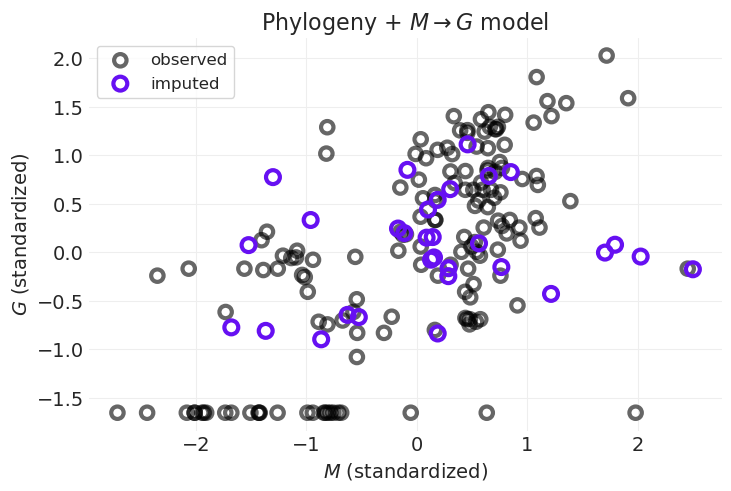

In [45]:
plot_posterior_imputation(
    "M", "G",
    G_imputation_inference,
    impute_y=True,
    impute_color='C4',
    title="Phylogeny + $M \\rightarrow G$ model"
)

- Purple points move toward the regression line

⚠️ for some reason, after trying two different implementation of GPs using PyMCs `gp` module, as well as using `MVNormal` likelihood (both give similar results), I'm not able to replicate the imputation for solo primates presented in lecture. 

**Comments and suggestions are welcome on what I may be doing incorrectly here**

<Axes: >

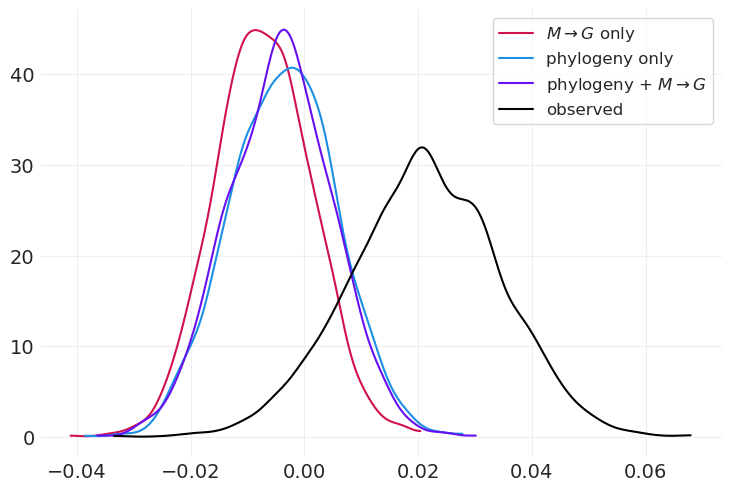

In [46]:
az.plot_dist(G_body_mass_inference.posterior['beta_GB'], color='C0', label='$M \\rightarrow G$ only')
az.plot_dist(G_phylogeny_inference.posterior['beta_GB'], color='C1', label='phylogeny only')
az.plot_dist(G_imputation_inference.posterior['beta_GB'], color='C4', label='phylogeny + $M \\rightarrow G$')
az.plot_dist(complete_case_inference.posterior['beta_G'], color='k', label='observed');

### 4. Impute $B,G,M$ using a submodel for each 


Below is an implementation that uses PyMC's Gaussian process module.

In [58]:
# with pm.Model() as full_model:
    
#     # Priors
#     sigma_M = pm.Exponential("sigma_M", 1

#     alpha_G = pm.Normal("alpha_G", 0, 1)
#     beta_MG = pm.Normal("beta_MG", 0, 1)
#     sigma_G = pm.Exponential("sigma_G", 1)
    
#     alpha_B = pm.Normal("alpha_B", 0, 1)
#     beta_GB = pm.Normal("beta_GB", 0, 0.5)
#     beta_MB = pm.Normal("beta_MB", 0, 0.5)
#     sigma_B = pm.Exponential("sigma_B", 1))

#     # Naive imputation for M
#     eta_squared_M = pm.TruncatedNormal("eta_squared_M", 1, .25, lower=.01)
#     rho_M = pm.TruncatedNormal("rho_M", 3, .25, lower=.01)
    
#     cov_func_M = eta_squared_M * pm.gp.cov.Exponential(1, ls=rho_M)
#     mean_func_M = pm.gp.mean.Zero()
    
#     gp_M = pm.gp.Marginal(mean_func=mean_func_M, cov_func=cov_func_M)
#     M = gp_M.marginal_likelihood("M", X=D_mat, y=M_obs, noise=sigma_M)

#     # G model, interactions only
#     mean_func_G = MeanBodyMassSocialGroupSize(alpha_G, 0, beta_MG, 0, M)

#     eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.01)
#     rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.01)
#     cov_func_G = eta_squared_G * pm.gp.cov.Exponential(1, ls=rho_G)

#     gp_G = pm.gp.Marginal(mean_func=mean_func_G, cov_func=cov_func_G)
#     G = gp_G.marginal_likelihood("G", X=D_mat, y=G_obs, noise=sigma_G)

#     # B Model
#     mean_func_B = MeanBodyMassSocialGroupSize(alpha_B, beta_GB, beta_MB, G, M)

#     eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.01)
#     rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.01)
#     cov_func_B = eta_squared_B * pm.gp.cov.Exponential(1, ls=rho_B)

#     gp_B = pm.gp.Marginal(mean_func=mean_func_B, cov_func=cov_func_B)
#     gp_B.marginal_likelihood("B", X=D_mat, y=B_obs, noise=sigma_B)
    
#     full_inference = pm.sample(target_accept=.95, cores=1)

Below is an alternative implementation that builds the covariance function by hand, and directly models the dataset as a `MVNormal` with mean being the linear function of $G$ and $M$, and covariance defined by the kernel. I find that these `MVNormal` implementations track better with the results from lecture.

In [57]:
coords = {'primate': PRIMATES['name'].values}
with pm.Model(coords=coords) as full_model:
    
    # Priors
    alpha_B = pm.Normal("alpha_B", 0, 1)
    beta_GB = pm.Normal("beta_GB", 0, 0.5)
    beta_MB = pm.Normal("beta_MB", 0, 0.5)

    alpha_G = pm.Normal("alpha_G", 0, 1)
    beta_MG = pm.Normal("beta_MG", 0, 0.5)

    # M model (imputation)
    eta_squared_M = pm.TruncatedNormal("eta_squared_M", 1, .25, lower=.001)
    rho_M = pm.TruncatedNormal("rho_M", 3, .25, lower=.001)

    K_M = pm.Deterministic('K_M', eta_squared_M * pm.math.exp(-rho_M * D_mat))
    mu_M = pm.math.zeros_like(M_obs)
    M = pm.MvNormal("M", mu=mu_M, cov=K_M, observed=M_obs)
    
    # G Model (imputation)
    eta_squared_G = pm.TruncatedNormal("eta_squared_G", 1, .25, lower=.001)
    rho_G = pm.TruncatedNormal("rho_G", 3, .25, lower=.001)

    K_G = pm.Deterministic('K_G', eta_squared_G * pm.math.exp(-rho_G * D_mat))
    mu_G = alpha_G + beta_MG * M
    G = pm.MvNormal("G", mu=mu_G, cov=K_G, observed=G_obs)

    # B Model
    eta_squared_B = pm.TruncatedNormal("eta_squared_B", 1, .25, lower=.001)
    rho_B = pm.TruncatedNormal("rho_B", 3, .25, lower=.001)
    K_B = pm.Deterministic('K_B', eta_squared_B * pm.math.exp(-rho_B * D_mat))

    # Likelihood for B
    mu_B = alpha_B + beta_GB * G + beta_MB * M
    pm.MvNormal("B", mu=mu_B, cov=K_B, observed=B_obs)
    
    full_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_B, beta_GB, beta_MB, alpha_G, beta_MG, eta_squared_M, rho_M, M_unobserved, eta_squared_G, rho_G, G_unobserved, eta_squared_B, rho_B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 205 seconds.


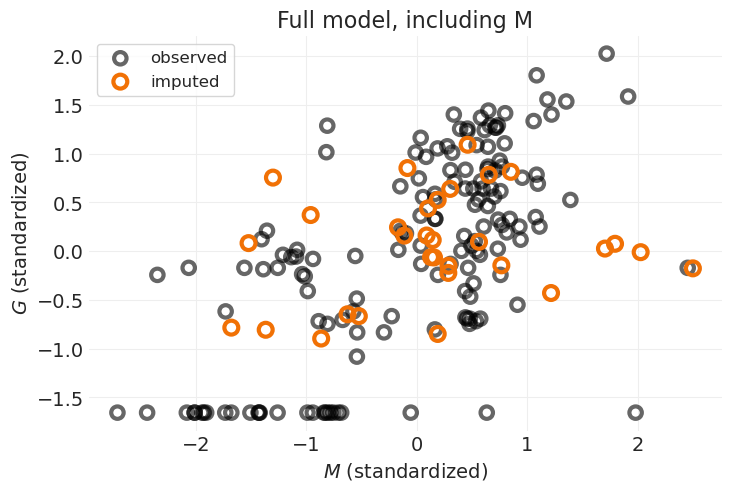

In [59]:
plot_posterior_imputation(
    "M", "G",
    full_inference,
    impute_y=True,
    impute_color='C5',
    title="Full model, including M"
)

Imputation changes little from the previous model that does not directly model the causes of $M$. I would think that this is because there are only two missing $M$ values

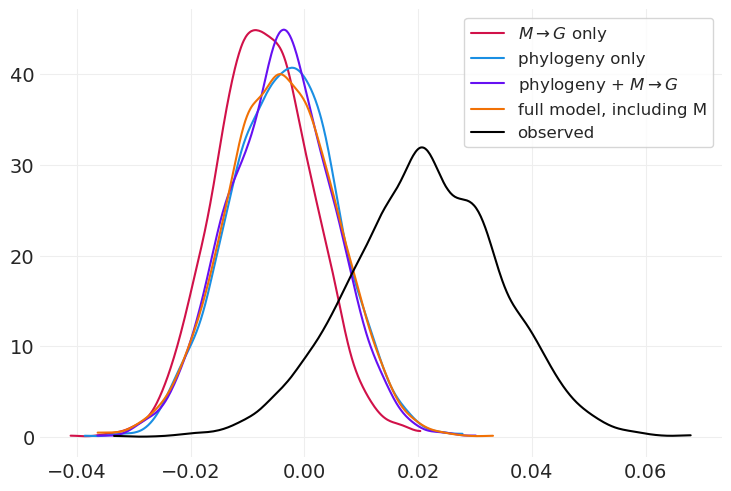

In [60]:
az.plot_dist(G_body_mass_inference.posterior['beta_GB'], color='C0', label='$M \\rightarrow G$ only')
az.plot_dist(G_phylogeny_inference.posterior['beta_GB'], color='C1', label='phylogeny only')
az.plot_dist(G_imputation_inference.posterior['beta_GB'], color='C4', label='phylogeny + $M \\rightarrow G$')
az.plot_dist(full_inference.posterior['beta_GB'], color='C5', label='full model, including M')
az.plot_dist(complete_case_inference.posterior['beta_G'], color='k', label='observed');

we also get very similare effects to the phylogeny + $M \rightarrow G$ model

## Review: Imputing Primates

- **Key Idea**: missing values have probability distributions
- Think like a graph, not like a regression
- Blind imputation without relationships among predictorrs may be risky
  - take advantage of partial pooling 
- Even if imputation doesn't change results, it's scientific duty 